# Stock Price Predictor

### Machine Learning Engineer Nanodegree - Capstone Project Report

----------------

## Introduction

### Project Overview

A stock market, also called equity market or share market, is a network of economic transactions, where the stocks of public companies can be bought and sold. The equity market offers companies the ability to access capital in exchange of a portion in the ownership of the company for interested outside parties.

In the stock market, other financial securities like exchange traded funds (ETF), corporate bonds and derivatives based on stocks, commodities, currencies, bonds, etc. can be traded. However, for purpose of this project only the exchange of stocks will be considered.

It is common to use stock market and stock exchange interchangeably, but the stock market is a general superset of the stock exchange. If someone is trading in the stock market, it means that it buys and sells stock/shares/equity on one (or more) of the stock exchange(s) that are part of the overall stock market.

The stock market offers an opportunity to investors to increase their income without the high risk of entering into their own businesses with high overheads and startup costs. On the other hand, selling stocks helps companies themselves to expand exponentially, when a company’s shares are purchased it is generally associated with the increased in the company’s worth. Therefore, trading on the stock market can be a win-win for both investor and owner.

The stock exchange that are leading the U.S. include the New York Stock Exchange (NYSE), Nasdaq, BATS and Chicago Board Options Exchange (CBOE). The Dow Jones Industrial Average (DJIA) is a price-weighted average of 30 significant stocks traded on the NYSE and the Nasdaq, it is the most closely watched market indicator in the world and it is generally perceived to mirror the state of American economy.

Projecting how the stock market will perform is a very difficult thing to do, there are so many factors involved in the prediction some of them emotional or irrational, which combined with the prices volatility make difficult to predict with a high degree of accuracy. Abundant information is available in the form of historical stock prices, which make this problem suitable for the use of machine learning algorithms.

Investment firms, hedge funds and individuals have been using financial models to better understand the market behavior and attempt to make projections in order to make profitable investments and trades.


### Problem Statement

The purpose of this project is to build a stock price predictor, more specifically, the problem is to predict the closing price of a given company's stock in the trading days existing in a queried date range. For the scope of this project only the companies included in the Dow Jones Industrial Average are considered.

To address the problem a supervised learning approach is taken, the strategy to follow is to approach the problem as a particular case of forecasting in time series. As in supervised learning, a generalized function is tried to be inferred from the existing data which already contains the ground truth, the difference with this approach is that the existing data is in the past and the data to predict in the future, i.e. there is a clear separation of the predictor's values used for training and prediction, instead of being mixed and distributed along the possible set of values.

The different machine learning methods used in this project take historical stock data for a particular company over a certain date range (in the past) as training input, and outputs projected estimates for a given queried date range (in the future). The following ones are the methods taken in this project to address the problem of making predictions about how the closing stock prices will perform:

* ARIMA (AutoRegressive Integrated Moving Average): It is a very popular statistical method for time series forecasting that takes into account the past values to predict the future values.
* Prophet: It is a time series forecasting library designed and pioneered by Facebook, that is claimed to be extremely simple to implement.
* LSTM (Long Short-Term Memory): It is a deep learning approach based in Recurrent Neural Networks (RNN) also used to make predictions in time series.

### Getting started

Importing the necessary libraries.

In [1]:
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
import os

import math
import random
import datetime
import pytz
import requests
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from pandas.io.json import json_normalize

from scipy.stats.stats import pearsonr


# Linear Regression
from sklearn.linear_model import LinearRegression

# Arima
from pyramid.arima import auto_arima

# Facebook's Prophet
from fbprophet import Prophet

# Long Short Term Memory
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


# Makes Keras picklable
from tools.make_keras_picklable import make_keras_picklable
make_keras_picklable()

/usr/local/lib/python3.5/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)
/usr/local/lib/python3.5/dist-packages/pyramid/_config.py:59: UserWarning: The Pyramid cache (/root/.pyramid-arima-cache) has grown to 157,456,425 bytes. Consider cleaning out old ARIMA models or increasing the max cache bytes with 'PYRAMID_ARIMA_CACHE_WARN_SIZE' (currently 100,000,000 bytes) to avoid this warning in the future.
  UserWarning)
Using TensorFlow backend.


----------------

## Dataset

The data is extracted from an API provided by IEX (which documentation can be found at https://iextrading.com/developer/docs/#chart) allows to retrieve historical stock price information for a maximum of 5 years back to the current date.

The API can provide historical records for several companies, but for this project only the records for the ones in the Dow Jones are retrieved.

### Common functions

The following ones are some useful functions to support the different constructions used in this project.

In [2]:
def expand_date_in_dataframe(df):
    """
    It breaks the date attibute (assuming it's a datetime) of a dataframe in more fileds
    for year, month, day, week, day of week and day of year.
    """
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear


def add_timestamp_to_dataframe(df):
    """
    It add a representation of the date attibute (assuming it's a datetime) as a timestamp.
    """
    df['timestamp'] = df.date.values.astype(np.int64)


def str_to_datetime(date):
    """
    Converts a string into a datetime.

    :param str date: The string representation in the format 'yyyy-mm-dd' of the date to convert.
    :return: The resulting datetime.
    :rtype: datetime.datetime
    """
    return datetime.datetime.strptime(date, '%Y-%m-%d')


def datetime_array_to_dataframe(days):
    """
    Gets a dataframe from an array of dates.

    :param list[datetime.datetime] date: The array of dates.
    :return: The dataframe.
    :rtype: pandas.DataFrame
    """
    return pd.DataFrame({'date': days})

### Dataset controller

The following class has the objective of creating objects capable of extractig the dataset's records from the IEX API, it also can update save and load the data. Also it provides methods to filter the dataset by date range or ticker symbol.

In [3]:
class Dataset:
    """
    This class is used to manage the dataset that contains the hsitoric stock prices
    for the companies contemplated in the Dow Jones Industrial Average.
    """

    """ Ticker symbols of the companies contemplated in the  Dow Jones Industrial Average. """
    DJIA_TICKERS = [
        'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
        'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
        'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

    """ This is the symbol used by the actual average, i.e. the Dow Jones Industrial Average. """
    DJIA_SYMBOL = 'DIA'

    """ Value used to get the historical data from 5 years ago. """
    HIST_5Y = '5y'

    """ Value used to get the historical data from 1 year ago. """
    HIST_1Y = '1y'

    """ Value used to get the historical data from 1 month ago. """
    HIST_1M = '1m'

    """
    This is the template to create the URL to extract historical stock prices
    from the IEX API.
    """
    __IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/{}'


    def __init__(self, dataframe=None):
        """
        The constructor of Dataset.

        :param pandas.DataFrame df: The dataframe containing stock price historical records,
                                    which will be actual data.
        """
        self.dataframe = dataframe


    @staticmethod
    def __preprocess_dataframe(df):
        """
        Pre-processes a dataframe containing stock price historical records (from IEX)
        by removing the columns that are not useful to make future predictions
        and expanding the date in more columns.

        :param pandas.DataFrame df: The dataframe containing stock price historical records.
        :return: The pre-processed dataframe.
        :rtype: pandas.DataFrame
        """
        formated_df = df.drop(['label',
                               'change', 'changeOverTime', 'changePercent',
                               'high', 'low', 'open',
                               'unadjustedVolume', 'volume', 'vwap'],
                              axis=1)

        return formated_df


    @staticmethod
    def __get_dataframe_for_ticker(ticker_symbol, hist_period):
        """
        Retrieves the historic prices for a particuler stock from the data source,
        i.e. the IEX API.

        :param str ticker_symbol: The ticker symbol or symbols to filter the data.
        :param str hist_period: The period to retrieve historical records,
                                p.e '5y' for 5 years, '1y' for 1 year, '1m' for 1 month, etc.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """
        # Getting the historic records from IEX
        r = requests.get(url=Dataset.__IEX_API_URL_TEMPLATE.format(ticker_symbol.lower(), hist_period))
        df = json_normalize(r.json())

        # Converting the date to a datetime
        df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

        # Adding the ticker symbol as a new column
        df.insert(loc=0, column='symbol', value=ticker_symbol)

        return Dataset.__preprocess_dataframe(df)


    @staticmethod
    def __get_djia_dataframe(hist_period):
        """
        Gets a dataframe containing historic prices for stocks in the Dow Jones Industrial Average.

        :param str hist_period: The period to retrieve historical records,
                                p.e '5y' for 5 years, '1y' for 1 year, '1m' for 1 month, etc.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """
        # Getting the historic records of the average
        df = Dataset.__get_dataframe_for_ticker(Dataset.DJIA_SYMBOL, hist_period)

        # Retrieves the historic records for each one of the ticker symbols in the
        # Dow Jones Industrial Average
        for ticker_symbol in Dataset.DJIA_TICKERS:
            df = df.append(Dataset.__get_dataframe_for_ticker(ticker_symbol, hist_period))

        return df


    @staticmethod
    def __update_djia_dataframe(df):
        """
        Updates a dataframe containing historic prices for stocks in the Dow Jones Industrial Average,
        by retrieving the most recent records from the information source.

        :param pandas.DataFrame hist_period: The dataframe containing stock price historical records.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """

        # Getting the amount of days that need to be updated
        last_recorded_day = max(df.date)
        today = datetime.datetime.now()
        days_to_update = (today - last_recorded_day).days

        # Deciding the historic period to request to the source according to the days that
        # need to be updated
        hist_period = Dataset.HIST_5Y
        if days_to_update < 1:
            return df
        elif days_to_update < 28:
            hist_period = Dataset.HIST_1M
        elif days_to_update < 365:
            hist_period = Dataset.HIST_1Y

        # Getting the data frame containing the missing records
        last_df = Dataset.__get_djia_dataframe(hist_period)

        # Appending the missing records, dropping the duplicates and returning
        return df.append(last_df).drop_duplicates(['symbol', 'date'], keep='last')


    @staticmethod
    def loadDatasetFromFile(file_name):
        """
        Loads the dataset from a file where data was previously stored.

        :param str file_name: The name of the file to load the data from. 
        """
        with open(file_name, 'rb') as fp:
            return Dataset(pickle.load(fp))


    def saveDataToFile(self, file_name=None):
        """
        Saves the current dataset to a file.

        :param file_name: The name of the file to save the data,
                          if None the data is saved to a file in the 'data' directory
                          using a name of the form 'djia_yyyymmdd-yyyymmdd.pkl'
                          with the minimum and maximum recorded dates. 
        :type file_name: str or None
        :return: The name of the file used to store the data.
        :rtype: str
        """
        if file_name is None:
            file_name = os.path.join(
                'data',
                'djia_{:%Y%m%d}-{:%Y%m%d}.pkl'.format(min(self.dataframe.date), max(self.dataframe.date)))

        with open(file_name, 'wb') as fp:
            pickle.dump(self.dataframe, fp)

        return file_name


    @staticmethod
    def createDataset(hist_period=HIST_5Y):
        """
        Creates a dataset with brand new data,
        by default it retrieves historical records from the last 5 years.

        :param str hist_period: The period to retrieve historical records, 5 years ('5y') by default.
        :return: The new dataset.
        :rtype: Dataset
        """
        return Dataset(Dataset.__get_djia_dataframe(hist_period))


    def updateData(self):
        """
        Updates the dataset by getting the most recent history records from the source.
        Note: This method is intended to be run periodicaly in order to keep the dataset up to date.
        """
        self.dataframe = Dataset.__update_djia_dataframe(self.dataframe)


    def getDataframe(self, ticker_symbol=None, from_date=None, to_date=None):
        """
        Gets a dataframe containing a subset of the records of the current dataset,
        which is obtained by filtering by a ticker symbol or list (array) of ticker symbols
        and/or a date range.

        :param ticker_symbol: The ticker symbol or symbols to filter the data.
        :type ticker_symbol: str or list[str] or None
        :param from_date: The minimum date to appear in the records of the subset.
        :type from_date: datetime.datetime or None
        :param to_date: The maximum date to appear in the records of the subset.
        :type to_date: datetime.datetime or None
        :return: The dataframe with the subset resulted of filtering the dataset.
        :rtype: pandas.DataFrame
        """
        df = self.dataframe

        if ticker_symbol is not None:
            if isinstance(ticker_symbol, str): # If ticker_symbol symbol is a string
                df = df.query("symbol == '{}'".format(ticker_symbol))
            elif isinstance(ticker_symbol, list): # If ticker_symbol symbol is an array
                # Creates a query expression as a sequence of ORs
                ticker_symbol_query = None
                for t in ticker_symbol:
                    ticker_symbol_exp = "symbol == '{}'".format(t)
                    if ticker_symbol_query is None:
                        ticker_symbol_query = ticker_symbol_exp
                    else:
                        ticker_symbol_query += "or " + ticker_symbol_exp
                df = df.query(ticker_symbol_query)

        if from_date is not None:
            df = df.query("date >= '{}'".format(from_date))

        if to_date is not None:
            df = df.query("date <= '{}'".format(to_date))

        return df



    def getSubset(self, ticker_symbol=None, from_date=None, to_date=None):
        """
        Gets a subset of the current dataset filtered 
        by a ticker symbol or list (array) of ticker symbols and/or a date range.

        :param ticker_symbol: The ticker symbol or symbols to filter the data.
        :type ticker_symbol: str or list[str] or None
        :param from_date: The minimum date to appear in the records of the subset.
        :type from_date: datetime.datetime or None
        :param to_date: The maximum date to appear in the records of the subset.
        :type to_date: datetime.datetime or None
        :return: The subset resulted of filtering the dataset.
        :rtype: Dataset
        """
        df = self.getDataframe(ticker_symbol=ticker_symbol, from_date=from_date, to_date=to_date)
        return Dataset(df)

### Trading days

A very important aspect to consider is that the market is closed on weekends and some defined holidays, the list of holidays for this project is defined in the file 'market_holidays.txt', this file can be edited accordingly to record any changes or extending the list to contemplete days in the future.

The following class has the objective of getting the trading days (i.e. the days that the stock market is open), in a date range or getting a given number of trading days ahead.

In [4]:
class TradingDaysHelper:
    """
    This is a helper to retrieve the days that the market is open.
    The market holidyas are loaded from a file, by default 'market_holidays.txt'.
    """

    def __init__(self, market_holidays_file='market_holidays.txt'):
        """
        The constructor.

        :param str market_holidays_file: The file containing the market holidays,
                                         by default 'market_holidays.txt'.
        """
        self.market_holidays = []

        with open(market_holidays_file) as f:
            lines = f.readlines()

        for line in lines:
            self.market_holidays.append(datetime.datetime.strptime(line.strip(), '%Y-%m-%d'))


    def __is_trading_day(self, day):
        """
        Verifies if in a particular day the market is open.

        :param datetime.datetime day: The day to verify if the marke is open.
        :return: True if the marke is open of False otherwise.
        :rtype: bool
        """
        day_of_week = day.weekday()
        if day_of_week == 5 or day_of_week == 6 or day in self.market_holidays:
            return False
        else:
            return True


    def get_trading_days_in_range(self, start_date, end_date):
        """
        Getting the trading days existing in a date range.

        :param datetime.datetime from_date: The starting date of the range.
        :param datetime.datetime to_date: The ending date of the range.
        :return: A list of the trading days in the specified date range.
        :rtype: list[datetime.datetime]
        """
        trading_days = []

        current_day = start_date
        while (current_day <= end_date):
            if self.__is_trading_day(current_day):
                trading_days.append(current_day)
            current_day += datetime.timedelta(days=1)

        return trading_days


    def get_trading_days_after(self, date, num_trading_days):
        """
        Getting a specific number of trading days after a given date.

        :param datetime.datetime date: The date after which training days are going to be retrieved.
        :param int num_trading_days: The number of training days to get.
        :return: A list containing the trading days.
        :rtype: list[datetime.datetime]
        """
        trading_days = []

        current_day = date
        while (len(trading_days) < num_trading_days):
            current_day += datetime.timedelta(days=1)
            if self.__is_trading_day(current_day):
                trading_days.append(current_day)

        return trading_days

### Data retrieval

The following code can be used to create a brand new dataset, which data is directly extracted from the IEX API. Then the dataset is saved into a file.

In [ ]:
ds = Dataset.createDataset()
dataset_filename = ds.saveDataToFile()
print('Dataset saved in file: {}'.format(dataset_filename))

The following code loads from a file a previously saved dataset.

In [5]:
dataset_filename = os.path.join('data', 'djia_20140324-20190322.pkl')
ds = Dataset.loadDatasetFromFile(dataset_filename)

The following code updates the dataset, this is done by adding the missing data from the date of the most recent records to the data recoverable till the current time via the IEX API. Then the dataset can be saved again to a file.

In [6]:
ds.updateData()
dataset_filename = ds.saveDataToFile()

----------------

## Data Exploration and Visualization

### Stock prices along the time

The following code has the objective of presenting a visualization of the historical closing prices for the 30 stocks of the companies in the Dow Jones.

The image at the top displays the prices along the time for all the companies.

The bottom image is a comparison with the actual Dow Jones Industrial Average index (highlighted in black).

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


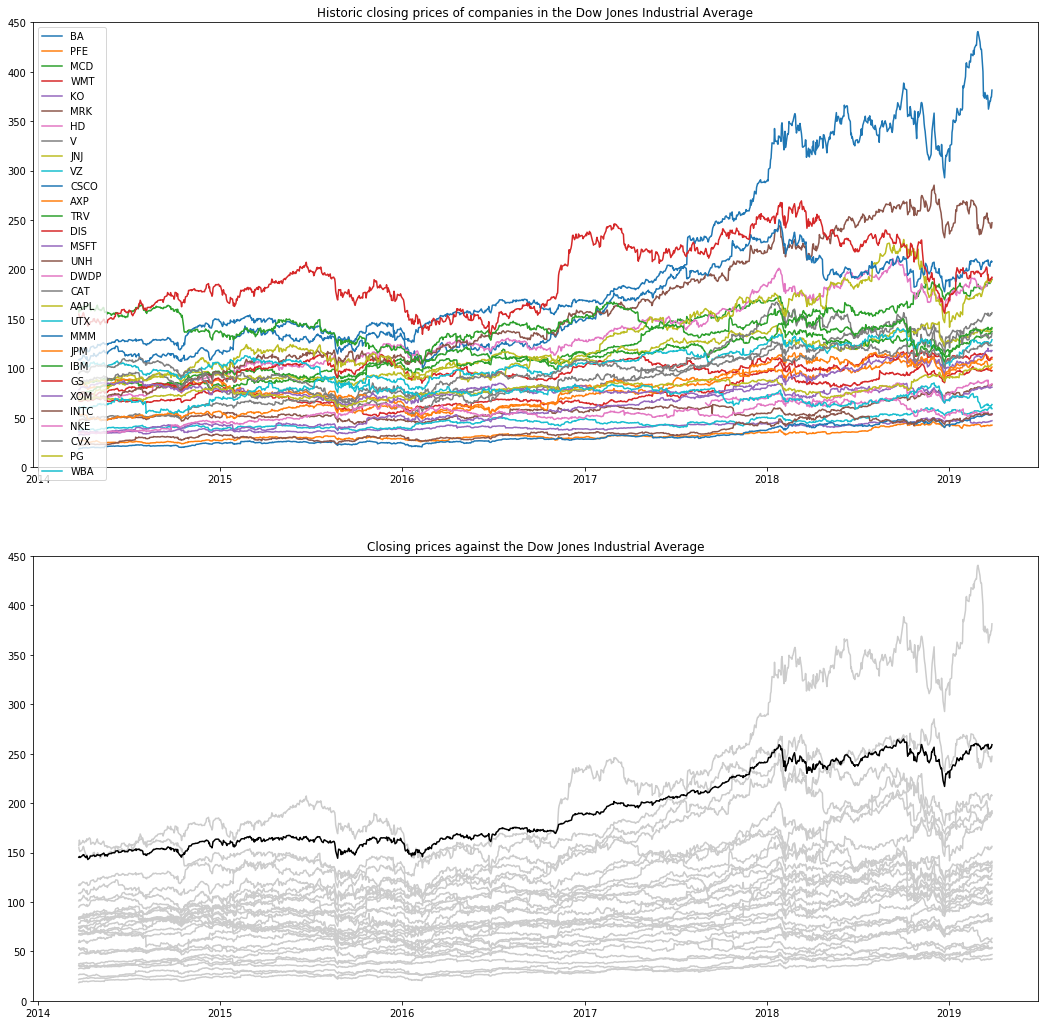

In [7]:
plotting_y_value = math.ceil(max(ds.dataframe.close) / 50) * 50

dia_df = ds.getDataframe(ticker_symbol=Dataset.DJIA_SYMBOL)

fig = plt.figure(figsize=(18, 18))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plotting the historical prices of all the 30 companies in the Dow Jones
for tkr in Dataset.DJIA_TICKERS:
    df = ds.getDataframe(ticker_symbol=tkr)
    ax1.plot(df.date, df.close, label=tkr)
ax1.set_title('Historic closing prices of companies in the Dow Jones Industrial Average')
ax1.legend()
ax1.set_autoscale_on(False)
ax1.set_ylim([0, plotting_y_value])

# Plotting in grey the historical prices of all the 30 companies
for tkr in Dataset.DJIA_TICKERS:
    df = ds.getDataframe(ticker_symbol=tkr)
    ax2.plot(df.date, df.close, color=(0.8, 0.8, 0.8))
# Plotting the historical prices of the actual Dow Jones Industrial Average
ax2.plot(dia_df.date, dia_df.close, label=Dataset.DJIA_SYMBOL, color='black')
ax2.set_title('Closing prices against the Dow Jones Industrial Average')
ax2.set_autoscale_on(False)
ax2.set_ylim([0, plotting_y_value])

plt.savefig(os.path.join('figures', 'historic_djia.png'))
plt.show()

### Stock historical prices per industry

The following is a visualization of the historical prices of the stocks, but this time grouped by industry type, they are also contrasted with the Dow Jones Industrial Average index (identified with the symbol DIA and plotted in a dotted black line).

[]

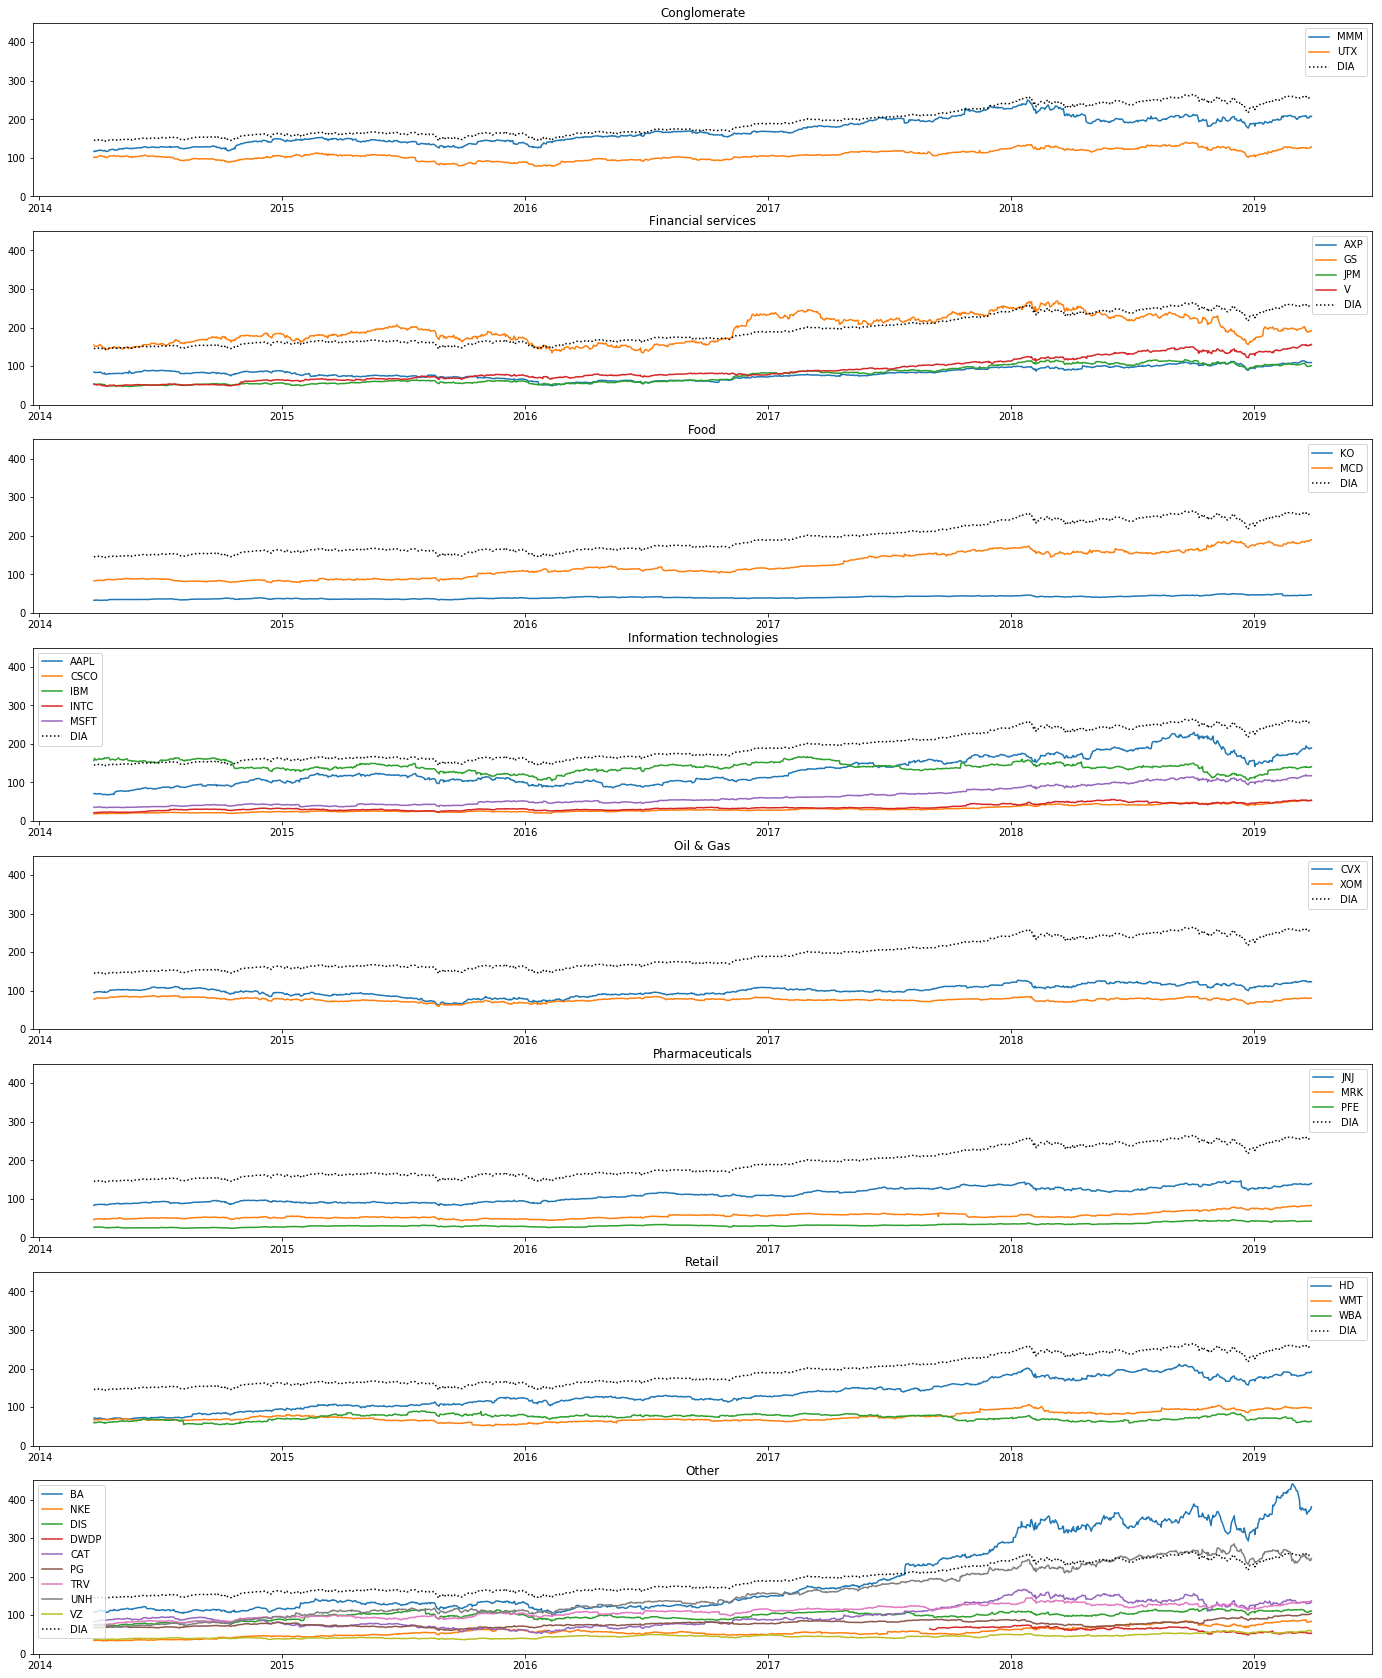

In [8]:
# This method plots the historic stock prices for a group of ticker symbols and adding a title
def plot_tickers_subset(subplot, title, ticker_symbols):
    for tkr in ticker_symbols:
        df = ds.getDataframe(ticker_symbol=tkr)
        subplot.plot(df.date, df.close, label=tkr)
    subplot.plot(dia_df.date, dia_df.close, label=Dataset.DJIA_SYMBOL, color='black', linestyle=':')
    subplot.legend()
    subplot.set_title(title)
    subplot.set_autoscale_on(False)
    subplot.set_ylim([0, plotting_y_value])

fig = plt.figure(figsize=(24, 30))

# Plotting the historical prices by groups (per industry) of ticker symbols
plot_tickers_subset(fig.add_subplot(811), 'Conglomerate', ['MMM', 'UTX'])
plot_tickers_subset(fig.add_subplot(812), 'Financial services', ['AXP', 'GS', 'JPM', 'V'])
plot_tickers_subset(fig.add_subplot(813), 'Food', ['KO', 'MCD'])
plot_tickers_subset(fig.add_subplot(814), 'Information technologies', ['AAPL', 'CSCO', 'IBM', 'INTC', 'MSFT'])
plot_tickers_subset(fig.add_subplot(815), 'Oil & Gas', ['CVX', 'XOM'])
plot_tickers_subset(fig.add_subplot(816), 'Pharmaceuticals', ['JNJ', 'MRK', 'PFE'])
plot_tickers_subset(fig.add_subplot(817), 'Retail', ['HD', 'WMT', 'WBA'])
plot_tickers_subset(fig.add_subplot(818),
                    'Other', ['BA', 'NKE', 'DIS', 'DWDP', 'CAT', 'PG', 'TRV', 'UNH', 'VZ'])

plt.savefig(os.path.join('figures', 'historic_djia_per_industry.png'))
plt.plot()

### Correlation among historical prices per each one of the stocks

The Dow Jones Industrial Average is calculated with the stock prices of 30 selected public large companies, then it is not surprising that most of these stocks are behaving in a similar way to the DJIA. To calculate the DJIA, the prices are added and then divided by the Dow divisor, which is constantly modified.

The following visualization shows the correlation of each one of the stocks in the Dow Jones against each other and against the actual DJIA. It can be observed that in most of the cases there is a high correlation, observed by a dominance of the red color in the matrix (which is the color to indicate a high correlation, i.e. close to 1), only 4 companies seem no to follow the same tendency as the the general DJIA.

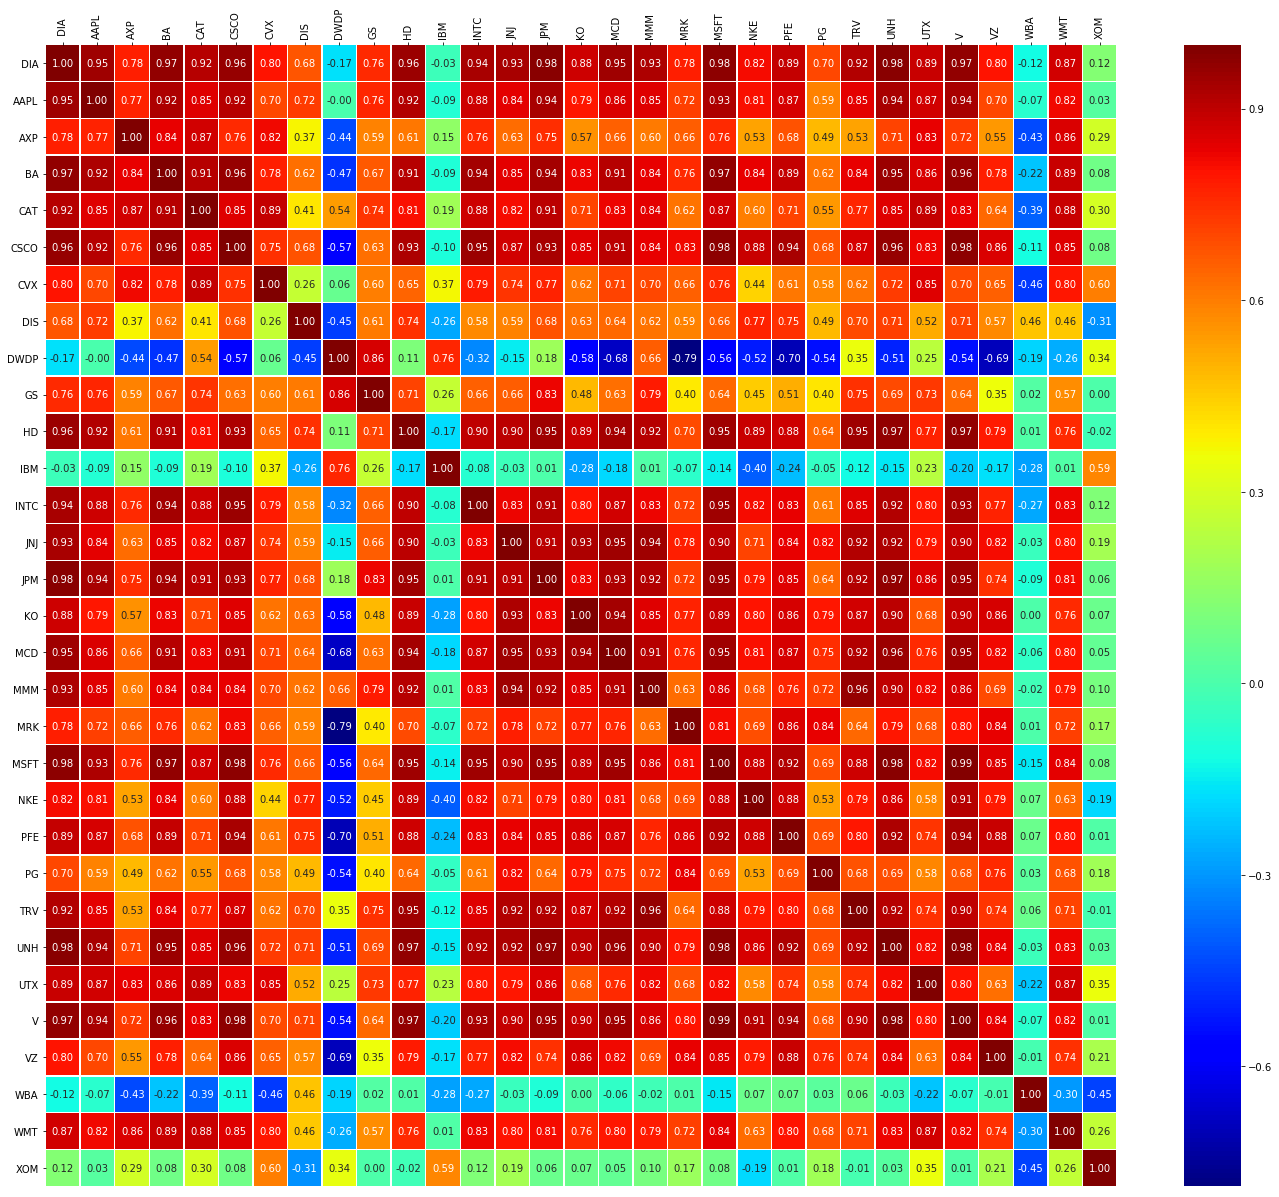

In [9]:
corr = []

# Calculating the correlation of each one of 30 ticker symbols in the Dow Jones
# againts each other and againts the actual Dow Jones Industrial Average
# The correlations are stored in an array of maps
for tkr_1 in np.concatenate((Dataset.DJIA_TICKERS, [Dataset.DJIA_SYMBOL])):
    df_1 = ds.getDataframe(ticker_symbol=tkr_1)
    for tkr_2 in np.concatenate((Dataset.DJIA_TICKERS, [Dataset.DJIA_SYMBOL])):
        df_2 = ds.getDataframe(ticker_symbol=tkr_2)

        corr.append({'symbol1': tkr_1 if tkr_1 != Dataset.DJIA_SYMBOL else ' '+tkr_1,
                     'symbol2': tkr_2 if tkr_2 != Dataset.DJIA_SYMBOL else ' '+tkr_2,
                     'correlation': pearsonr(df_1.close[len(df_1)-min(len(df_1), len(df_2)):],
                                             df_2.close[len(df_2)-min(len(df_1), len(df_2)):])[0]
                    })

# Converting the array of correlations to a dataframe
corr_df = pd.DataFrame(columns = ['symbol1', 'symbol2', 'correlation'], data = corr)


fig = plt.figure(figsize=(24, 21))
ax1 = fig.add_subplot(111)

# Plotting the correlations as a heat-map, as a matrix
sns.heatmap(corr_df.pivot_table(index='symbol1', columns='symbol2', values='correlation'),
            annot=True, fmt='0.2f', linewidths=0.5, cmap='jet', ax=ax1)
ax1.xaxis.set_ticks_position('top')
ax1.set_xlabel('')
ax1.set_ylabel('')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.savefig(os.path.join('figures', 'correlation_djia_stocks.png'))
plt.show()

----------------

## ML Methods/Models

In this section the Machine Learning methods/models used in this project are implemented, an object oriented approach is taken where each method/model is implemented in a class.

The different objects have methods to perform the training and do predictions. For convenience the models can be saved to files with the purpose to reuse them. 

The following is a super class that represents a generic model, the specific models inherit from it. Methods to load and save the model are implemented in here, since they are common to all the models.

In [10]:
class StockForecasterModel:
    """
    This is a super-class to represent ML models/methods to perform predictions
    for the stock closing price for a particular company.
    """

    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        self.short_name = None
        self.long_name = None

        self.ticker_symbol = ticker_symbol

        self.training_start = None
        self.training_end = None

        if trading_days_helper is None:
            self.trading_days_helper = TradingDaysHelper()
        else:
            self.trading_days_helper = trading_days_helper


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        raise NotImplementedError('Please Implement this method.')


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: The dataset used to support the prediction,
                             in case that the model supports that.
        :type base_dataset: Dataset or None
        :return: A dataframe containing the date of the trading days in the given range
                 and their respective predicted closing price.
        :rtype: pandas.DataFrame
        """
        raise NotImplementedError('Please Implement this method.')


    @staticmethod
    def loadFromFile(file_name):
        """
        Loads the model from a file.

        :param str file_name: The name of the file to load the model from. 
        """
        with open(file_name, 'rb') as fp:
            return pickle.load(fp)


    def saveToFile(self, file_name=None):
        """
        Saves the current model to a file.

        :param file_name: The name of the file to save the model,
                          if None the data is saved to a file in the 'data' directory
                          using a name of the form 'model_name_ticker_yyyymmdd-yyyymmdd.pkl'
                          with the minimum and maximum dates used for training. 
        :type file_name: str or None
        :return: The name of the file used to store the model.
        :rtype: str
        """
        if file_name is None:
            file_name = os.path.join(
                'data',
                'model_{}_{}_{:%Y%m%d}-{:%Y%m%d}.pkl'.format(
                    self.short_name, self.ticker_symbol, self.training_start, self.training_end))

        with open(file_name, 'wb') as fp:
            pickle.dump(self, fp)

        return file_name

### Linear Regression

Linear regression is the first and naive Machine Learning method implemented, the idea is just to obtain the regression line for the closing prices against the dates. This is the one that is going to be used to **benchmark** the other methods during the evaluation.

In [11]:
class LinearRegressionStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based on linear regression.
    """

    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'LinearRegression'
        self.long_name = 'Linear Regression'


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range.')

        training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)

        self.training_start = min(training_set.date)
        self.training_end = max(training_set.date)

        # Pre-Processing
        # Only the timestamp (which is a numeric value) is considered as predictor,
        # since the linear regresion does not support datetimes
        add_timestamp_to_dataframe(training_set)
        x = training_set[['timestamp']]
        y = training_set.close

        self.model = LinearRegression()
        self.model.fit(x, y)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: This is not supported for this model.
        :type base_dataset: Dataset or None
        :return: A dataframe containing the date of the trading days in the given range
                 and their respective predicted closing price.
        :rtype: pandas.DataFrame
        """
        if from_date is None:
            raise ValueError('Invalid initial date.')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict.')

        if base_dataset is not None:
            warnings.warn("Prediction using a base dataset is not supported.")

        # Getting the trading days in the predicting date range
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(from_date, to_date)
        x_train = datetime_array_to_dataframe(days_to_predict)

        # Pre-Processing
        # Only the timestamp (which is a numeric value) is considered as predictor,
        # since the linear regresion does not support datetimes
        add_timestamp_to_dataframe(x_train)
        x_train = x_train[['timestamp']]

        y = self.model.predict(x_train)
        
        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y})

### Linear Regression applied to the components of the date

The idea behind this method is that the following components of a date can play a role in determining the closing price of a stock:
* Year
* Month
* Day
* Week
* Day of week
* Day of year

For this method the linear regression is improved to take as predictors the mentioned date components, instead of just the date as a numerical value.

In [12]:
class DateComponentsLinearRegressionStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based on linear regression.
    """

    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'DateCompLinearRegression'
        self.long_name = 'Linear Regression - Date Components'


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range.')

        training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)

        self.training_start = min(training_set.date)
        self.training_end = max(training_set.date)

        # Pre-Processing
        # The date is break down in: year, month, day, week, day-of-Week and day-of-year
        # which are used as pedictors
        expand_date_in_dataframe(training_set)
        x = training_set.drop(['symbol', 'date', 'close'], axis=1)
        y = training_set.close

        self.model = LinearRegression()
        self.model.fit(x, y)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: This is not supported for this model.
        :type base_dataset: Dataset or None
        :return: A dataframe containing the date of the trading days in the given range
                 and their respective predicted closing price.
        :rtype: pandas.DataFrame
        """
        if from_date is None:
            raise ValueError('Invalid initial date.')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict.')

        if base_dataset is not None:
            warnings.warn("Prediction using a base dataset is not supported.")

        # Getting the trading days in the predicting date range
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(from_date, to_date)
        x_train = datetime_array_to_dataframe(days_to_predict)

        # Pre-Processing
        # The date is break down in: year, month, day, week, day-of-Week and day-of-year
        # which are used as pedictors
        expand_date_in_dataframe(x_train)
        x_train = x_train.drop(['date'], axis=1)

        y = self.model.predict(x_train)
        
        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y})

### ARIMA (AutoRegressive Integrated Moving Average)

It is a very popular statistical method for time series analysis and forecasting, its acronym is descriptive, capturing the key aspects of the model itself:

  * AR (Autoregression): A model that uses the dependent relationship between an observation and some number of lagged observations.
  * I (Integrated). The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
  * MA (Moving Average): A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [13]:
class ArimaStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based on Arima.
    """

    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'Arima'
        self.long_name = 'Arima'


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)
        self.training_start = min(training_set.date)
        self.training_end = max(training_set.date)

        # Pre-Processing
        # ARIMA only receives as sequence of value in the training,
        # then only the sequence of closing prices is needed
        training_set = training_set.close

        self.model = auto_arima(training_set,
                                start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0,
                                seasonal=True, d=1, D=1, trace=True,
                                error_action='ignore', suppress_warnings=True)
        self.model.fit(training_set)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: This is not supported for this model.
        :type base_dataset: Dataset or None
        :return: A dataframe containing the date of the trading days in the given range
                 and their respective predicted closing price.
        :rtype: pandas.DataFrame
        """
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        if base_dataset is not None:
            warnings.warn("Prediction using a base dataset is not supported.")

        # Getting the trading days to predict, including some gaps between the end of the training
        # and the begining of the prediction range
        prediction_start = self.training_end + datetime.timedelta(days=1)
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        # Pre-Processing
        # For ARIMA only the number of future points to predict is required,
        # then only the number of trading days to predict need to be calculated
        y = self.model.predict(n_periods=len(days_to_predict))
        
        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y}
                           )\
                 .query("date >= '{}' and date <= '{}'".format(from_date, to_date))
                 # Filtering to get just the days in the given prediction range

### Prophet

It is an open source forecasting tool developed by Facebook, it is optimized for the business forecast tasks encountered at Facebook. They claim that the default settings produce forecasts that are often accurate as those produced by skilled forecasters, with much less effort.

In [14]:
class ProphetStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based on Facebook's Prophet.
    """

    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'Prophet'
        self.long_name = 'Prophet'


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        self.training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                      from_date=start_date, to_date=end_date)
        self.training_start = min(self.training_set.date)
        self.training_end = max(self.training_set.date)

        # Pre-Processing
        # Prophet takes the dates as predictors in a column called 'ds',
        # and the outcomes in a column called 'y',
        # then the columns 'date' needs to be renamed as 'ds', and 'close' as 'y'
        self.training_set = pd.DataFrame(self.training_set, columns=['date', 'close'])
        self.training_set.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

        self.model = Prophet(daily_seasonality=True)
        self.model.fit(self.training_set)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: This is not supported for this model.
        :type base_dataset: Dataset or None
        :return: A dataframe containing the date of the trading days in the given range
                 and their respective predicted closing price.
        :rtype: pandas.DataFrame
        """
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        if base_dataset is not None:
            warnings.warn("Prediction using a base dataset is not supported.")

        # Getting the trading days to predict, including some gaps between the end of the training
        # and the begining of the prediction range
        prediction_start = self.training_end + datetime.timedelta(days=1) 
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        # Pre-Processing
        # For Prophet only the number of future points to predict is required,
        # then only the number of trading days to predict need to be calculated
        x = self.model.make_future_dataframe(periods=len(days_to_predict))

        y = self.model.predict(x)['yhat'][self.training_set.shape[0]:]

        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y})\
                 .query("date >= '{}' and date <= '{}'".format(from_date, to_date))
                 # Filtering to get just the days in the given prediction range

### LSTM (Long Short-Term Memory)

A Recurrent Neural Network (RNN) can be thought of as multiple copies of the same network, each passing a message to a successor, aiming for them to learn from the past. RNNs are good in handling sequential data but they have two main problems, the first one called "Vanishing/Exploding Gradient problem" presented as a result of the weights being repeated several times, and the second one called "Long-Term Dependencies problem" that happens when the context is far away.

Long Short-Term Memory networks are a special kind of RNNs (introduced by Hochreiter & Schmidhuber in 1997 http://www.bioinf.jku.at/publications/older/2604.pdf) with capability of handling Long-Term dependencies and also provide a solution to the Vanishing/Exploding Gradient problem. They are currently used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

In [15]:
class LongShortTermMemoryStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based Long Short Term Memory
    (with Recurrent Neural Networks).
    """

    def __init__(self, ticker_symbol, trading_days_helper=None, timesteps=60, training_epocs=2):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'LSTM'
        self.long_name = 'Long Short Term Memory'
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.timesteps = timesteps
        self.training_epocs = training_epocs


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        self.training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                      from_date=start_date, to_date=end_date)
        self.training_start = min(self.training_set.date)
        self.training_end = max(self.training_set.date)

        # Pre-Processing
        # LSTM takes as predictors sequences of a given length (time-steps) containing
        # consecutive values in a time sequence,
        # the outcome is the following value in the time sequence.
        # Also the values should be scaled to the range from 0 to 1.

        # The sequence of closing prices is needed as a dataframe
        self.training_set = pd.DataFrame(self.training_set, columns=['close'])
        # Scaling the closing prices to the range 0 to 1
        scaled_training_set = self.scaler.fit_transform(self.training_set)

        # Getting an array of sequences of size (self.timesteps) of consecutive closing prices
        # and an array with the outcomes
        x_train, y_train = [], []
        for i in range(self.timesteps, len(scaled_training_set)):
            x_train.append(scaled_training_set[i - self.timesteps : i, 0])
            y_train.append(scaled_training_set[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)

        # Re-shaping the input to feed the LSTM network
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        # Creating and fitting the LSTM network
        self.model = Sequential()
        self.model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        self.model.add(LSTM(units=50))
        self.model.add(Dense(1))

        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.model.fit(x_train, y_train, epochs=self.training_epocs, batch_size=1, verbose=2)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: The dataset used to support the prediction.
        :type base_dataset: Dataset or None
        :return: A dataframe containing the date of the trading days in the given range
                 and their respective predicted closing price.
        :rtype: pandas.DataFrame
        """
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        # Getting the trading days to predict, including some gaps between the end of the training
        # and the begining of the prediction range
        prediction_start = self.training_end + datetime.timedelta(days=1) 
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        # If a base (updated) dataset is used taking the previous values from there,
        # otherwise taking them from the training set
        if base_dataset is not None:
            inputs = base_dataset.dataframe.query(
                "symbol == '{}' and date <= '{}'"\
                .format(self.ticker_symbol, self.training_end))\
                .close.values
        else:
            inputs = self.training_set.close.values

        # The array 'inputs' contains the closing prices in the time sequence,
        # it is initially loaded with self.timesteps elements which
        # last element corresponds to the date when the training ended. 
        inputs = inputs[len(inputs) - self.timesteps:]
        inputs = inputs.reshape(-1,1)
        inputs = self.scaler.transform(inputs).reshape(-1)

        y = []

        for i in range(0, len(days_to_predict)):
            # Taking the next sequence of size self.timesteps of closing prices from 'inputs'
            x = np.array(inputs[i : i + self.timesteps])
            # Re-shaping to be used by the LSTM as input
            x = np.reshape(x, (1, self.timesteps, 1))

            # Predicting the next value in the time sequence (it needs to be scaled back)
            pred = self.model.predict(x)
            y.append(self.scaler.inverse_transform(pred).reshape(-1)[0])

            # If a base (updated) dataset is used taking the following value in the time sequence
            # from there if it exists (it should be scaled), otherwise taking the predicted value.  
            existing_rec = base_dataset.dataframe.query(
                "date == '{}' and symbol == '{}'".format(days_to_predict[i], self.ticker_symbol)) \
                if base_dataset is not None else None
            if existing_rec is not None and len(existing_rec) > 0:
                inputs = np.append(
                    inputs, self.scaler.transform(existing_rec.close.values.reshape(-1,1)).reshape(-1)[0])
            else:
                inputs = np.append(inputs, pred)

        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y})\
                 .query("date >= '{}' and date <= '{}'".format(from_date, to_date))
                 # Filtering to get just the days in the given prediction range

----------------

## Evaluation

### Metric definition

The following is the function to calculate the RMSE (Root Mean Square Error) which is the metric used in this project to meassure the performance.

In [16]:
def rmse(predictions, targets):
    """
    Calculates the RMSE applied to two sets: prediction and target (intended to be the ground truth). 
    """
    return np.sqrt(((predictions - targets) ** 2).mean())

### Automating the evaluation process

The following function takes a dataset and generate two subsets for a given ticker symbol, one for training and one for validation. It received the date range for training and the number of trading days ahead (after training) for validation.

In [17]:
def get_training_and_validation_sets(dataset, trading_days_helper,
                                     ticker_symbol, training_start, training_end, validation_days):
    """
    Extract training and validation sets from a given dataset.
    The training set is created with records in the given date range for the training.
    The validation set is created with records from the day after the training day and
    to the date in which the number of requested validation days is covered with trading days.

    :param Dataset dataset: The dataset used to extract the training and validation sets from.
    :param TradingDaysHelper trading_days_helper: The helper object to get the days that the market is open.
    :param str ticker_symbol: The ticker symbol to perform predictions for.
    :param datetime.datetime training_start: The minimum date for the records used in the training set.
    :param datetime.datetime training_end: The maximum date for the records used in the training set.
    :param list[int] validation_days: The number of trading days after the training_end used to create
                                      the validation set.
    """

    # Calculatind the validation data ranges according to the number of trading days ahead for validation
    validation_trading_days = trading_days_helper.get_trading_days_after(training_end, max(validation_days))
    validation_start = min(validation_trading_days)
    validation_end = max(validation_trading_days)

    # Getting the training set
    training_ds = dataset.getSubset(ticker_symbol=ticker_symbol,
                                    from_date=training_start, to_date=training_end)
    # Getting the validation set
    validation_ds = dataset.getSubset(ticker_symbol=ticker_symbol,
                                      from_date=validation_start, to_date=validation_end)

    return training_ds, validation_ds

The following function performs the measure of the performance in terms of RMSE for a specific model, for a given number of validation days. It stores the results in a given array and plots a graph to compare the prediction against the validation values.

In [18]:
def measure_performance(results, subplot, title, model,
                        base_dataset, training_dataset, validation_dataset, validation_days):
    """
    Measures the perfomance of a model in terms of RMSE, reporting the results and 
    plotting a graph to compare the prediction against the validation values.

    :param list[list{}] results: The array to store the results in.
    :param matplotlib.pyplot.subplot subplot: The subplot to use to plot the graph 
                                              to compare predictions against validation.
    :param str title: The title attached to the graph.
    :param StockForecasterModel model: The model which performance is being measured.
    :param base_dataset: The data set used as a support of the prediction (only used for LSTM).
    :type base_dataset: Dataset or None
    :param Dataset training_dataset: The training set.
    :param Dataset validation_dataset: The validation set.
    :param list[int] validation_days: The number of trading days after the training used to perform
                                      the validation.
    """

    validation_start = min(validation_dataset.dataframe.date)
    validation_end = max(validation_dataset.dataframe.date)

    # Getting the predicted values
    preds = model.predict(validation_start, to_date=validation_end, base_dataset=base_dataset)

    # Reporting the results for each one of requested number of validation days ahead
    for v in validation_days:
        results.append({'method': title,
                        'symbol': model.ticker_symbol,
                        'forecasting_days': v,
                        'RMSE': rmse(preds.predicted_price.values[:v],
                                     validation_dataset.dataframe.close.values[:v])})

    # Ploting the graph to compare the predicted closing prices agaings the ones in the validation set
    subplot.plot(training_dataset.dataframe.date, training_dataset.dataframe.close, label='Training')
    subplot.plot(validation_dataset.dataframe.date, validation_dataset.dataframe.close, label='Validation')
    subplot.plot(preds.date, preds.predicted_price, label='Prediction')
    subplot.set_title(title)
    subplot.legend()

The following methods are used to automate the evaluation process, i.e. for a given ticker symbol and training date range it creates and trains the models used in this project and performs the performance meassure for each one of them. The results are reported in a dataframe, and plots graphs comparing the predicted against the validation closing prices for each model.

In [19]:
def build_or_retrieve_model(file_name, model_constructor, ticker_symbol,
                            training_dataset, training_start, training_end,
                            trading_days_helper):
    """
    Creates, trains ans save a model if not previously saved, or loaded if the model
    was previously saved in the specific file.

    :param str filename: The file to use for saving the model.
    :param Function model_constructor: The constructor for the model.
    :param str ticker_symbol: The ticker symbol to train the model and perform predictions for.
    :param Dataset training_dataset: The training set.
    :param datetime.datetime training_start: The minimum date for the records used in the training set.
    :param datetime.datetime training_end: The maximum date for the records used in the training set.
    :param TradingDaysHelper trading_days_helper: The helper object to get the days that the market is open.
    :return: The model either created and trained, or loaded.
    :rtype: StockForecasterModel
    """
    if os.path.isfile(file_name):
        return StockForecasterModel.loadFromFile(file_name)
    else:
        model = model_constructor(ticker_symbol, trading_days_helper=trading_days_helper)
        model.train(training_dataset, training_start, training_end)
        model_file = model.saveToFile(file_name)
        return model


def perform_evaluation(eval_id, dataset, ticker_symbol, training_start, training_end):
    """
    This functions does a performance meassurement for each one of the models used in this project
    returns the results and
    plots graphs comparing the predicted against the validation closing prices for each model.

    :param str filename: The identifier of the evaluation, used as prefix to save the models and plots.
    :param str ticker_symbol: The ticker symbol to train the model and perform predictions for.
    :param datetime.datetime training_start: The minimum date for the records used in the training set.
    :param datetime.datetime training_end: The maximum date for the records used in the training set.
    :return: A dataframe containing the results of the evaluation.
    :rtype: pandas.DataFrame
    """
    trading_days_helper = TradingDaysHelper()
    validation_days = [1, 5, 10, 20, 40, 60, 120]
    model_constructors = [LinearRegressionStockForecaster,
                          DateComponentsLinearRegressionStockForecaster,
                          ArimaStockForecaster,
                          ProphetStockForecaster,
                          LongShortTermMemoryStockForecaster]

    models = []

    training_dataset, validation_dataset = get_training_and_validation_sets(
        dataset, trading_days_helper, ticker_symbol, training_start, training_end, validation_days)

    training_and_validation_dataset = Dataset(
        pd.concat([training_dataset.dataframe, validation_dataset.dataframe]))

    # Retrieving the trained models
    for model_constructor in model_constructors:
        model = build_or_retrieve_model(
            os.path.join('evaluation', eval_id + '_' + model_constructor.__name__ + '.pkl'),
            model_constructor, ticker_symbol, training_dataset, training_start, training_end, trading_days_helper)
        models.append(model)


    results = []

    fig = plt.figure(figsize=(18, 21))
    n_rows = len(models) + 1

    i = 1
    for model in models:
        ax = fig.add_subplot(n_rows, 1, i)
        i = i + 1
        # Measuring the performance of the model
        measure_performance(
            results, ax, model.long_name, model,
            None, training_dataset, validation_dataset, validation_days)

        if isinstance(model, LongShortTermMemoryStockForecaster):
            ax = fig.add_subplot(n_rows, 1, i)
            i = i + 1
            # For LTSM an additional prediction mechanism simulating daily prediction is used
            measure_performance(
                results, ax, model.long_name + ' - daily prediction', model,
                training_and_validation_dataset, training_dataset, validation_dataset, validation_days)

    # Saving the plot with graphs comparing predictions against validation closing prices
    plt.savefig(os.path.join('evaluation', eval_id + '.png'))
    plt.show()

    return pd.DataFrame(columns = ['method', 'symbol', 'forecasting_days', 'RMSE'], data = results)

The following methods are used to display the results of an evaluation process, they aim to present the results in an user friendly way.

In [20]:
def color_negative_red(value):
    """
    This function is used to display negative values in red, possitive ones in gren 
    and zero in black, when displaying a dataframe.
    """
    if value < 0:
        color = 'red'
    elif value > 0:
        color = 'green'
    else:
        color = 'black'
    return 'color: {}'.format(color)


def highlight_max(s):
    """ This function is used to highlight the maximum value of a column when displaying a dataframe """
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    """ This function is used to highlight the minimum value of a column when displaying a dataframe """
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]


def create_rmse_report(results):
    """
    Creates a display of the result of an evaluation based on RMSE performance
    highlighting the results of the models that achieve the best results
    (i.e. RMSE closer to zero) per number of validation days.
    """
    return results.pivot(index='method', columns='forecasting_days', values=['RMSE'])\
                  .style.apply(highlight_min, subset=['RMSE'])


def create_improvement_report(results):
    """
    Creates a display of the result of an evaluation based on RMSE performance
    in regards to the percentage of improvement against the benchmarking model,
    highlighting the results of the models that achieve the best results
    (i.e. higher percentage) per number of validation days.

    Note: An improvement of 100% means that there was no error in the prediction,
    an improvement of 0% means that it behaves the same as the linear regression,
    and a negative improvement means that the error (RMSE) was bigger than 
    using linear regression.
    """

    linear_regression_results = results.query("method == 'Linear Regression'")\
                                       .rename(columns={'RMSE': 'LR_RMSE'})\
                                       .drop(['method'], axis=1)
    report = results.query("method != 'Linear Regression'")
    report = pd.merge(report, linear_regression_results, on=['symbol', 'forecasting_days'])
    report['improvement'] = (report['LR_RMSE'] - report['RMSE']) / report['LR_RMSE']
    report = report.drop(['LR_RMSE'], axis=1)
    report = report.pivot(index='method', columns='forecasting_days', values=['improvement'])
    report = report.style.applymap(color_negative_red, subset=['improvement'])\
                         .apply(highlight_max, subset=['improvement'])\
                         .format('{:.2%}', subset=['improvement'])
    return report

### Evaluation examples

#### 1st Example

In this first example, it is performed an evaluation taking the ticker symbol AAPL (Apple Inc.) in a period where the stock market seemed to have a tendency to increase, around the end of the first quarter of 2018. 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3009.708, BIC=3032.755, Fit time=6.596 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3490.967, BIC=3500.185, Fit time=0.085 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3266.890, BIC=3285.327, Fit time=1.126 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3009.235, BIC=3027.673, Fit time=2.983 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3009.268, BIC=3032.315, Fit time=3.060 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3491.439, BIC=3505.267, Fit time=0.306 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3009.178, BIC=3032.224, Fit time=9.764 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3009.993, BIC=3037.649, Fit time=22.793 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=3007.523, BIC=3025.961, Fit time=6.379 seconds
Fit ARIMA: order=(0, 1, 0) 

/usr/local/lib/python3.5/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


Epoch 1/2
 - 176s - loss: 0.0062
Epoch 2/2
 - 174s - loss: 0.0018


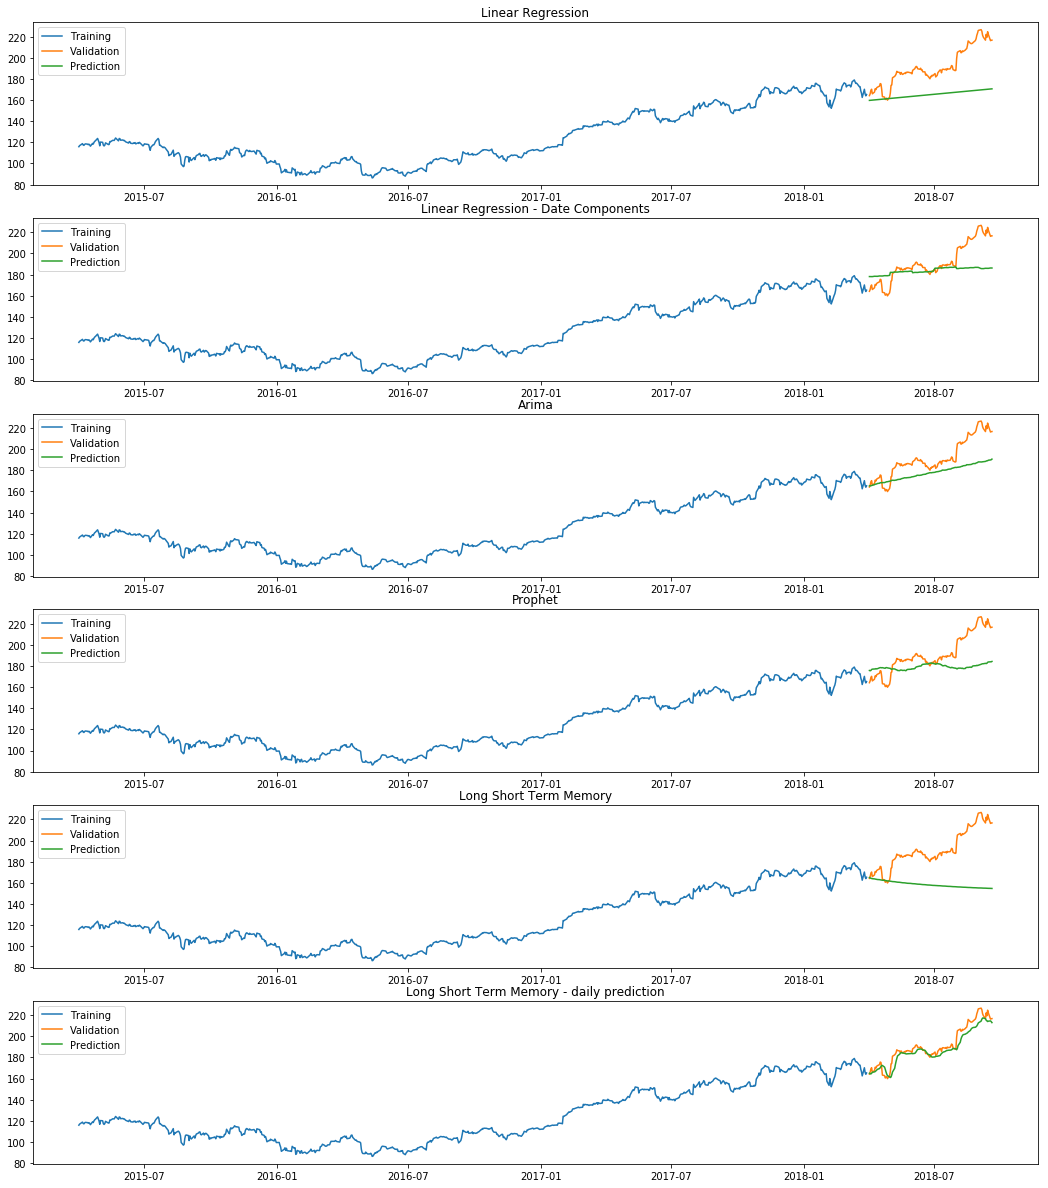

In [21]:
ds = Dataset.loadDatasetFromFile(dataset_filename)
results = perform_evaluation('eval1', ds, 'AAPL', str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))

In [22]:
create_rmse_report(results)

In [23]:
create_improvement_report(results)

#### 2nd Example

In this second example, it is performed an evaluation taking again the ticker symbol AAPL (Apple Inc.), this time in a period where there was a big drop in the stock market around the end of 2018. 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3094.761, BIC=3117.814, Fit time=6.701 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3586.129, BIC=3595.350, Fit time=0.084 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3370.065, BIC=3388.508, Fit time=1.157 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3092.764, BIC=3111.206, Fit time=4.679 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3092.619, BIC=3115.672, Fit time=5.731 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3369.985, BIC=3388.428, Fit time=1.073 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3095.905, BIC=3123.569, Fit time=25.867 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3582.797, BIC=3596.629, Fit time=0.332 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3094.876, BIC=3127.151, Fit time=34.006 seconds
Fit ARIMA: order=(1, 1, 1)

/usr/local/lib/python3.5/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


Epoch 1/2
 - 173s - loss: 0.0027
Epoch 2/2
 - 172s - loss: 0.0013


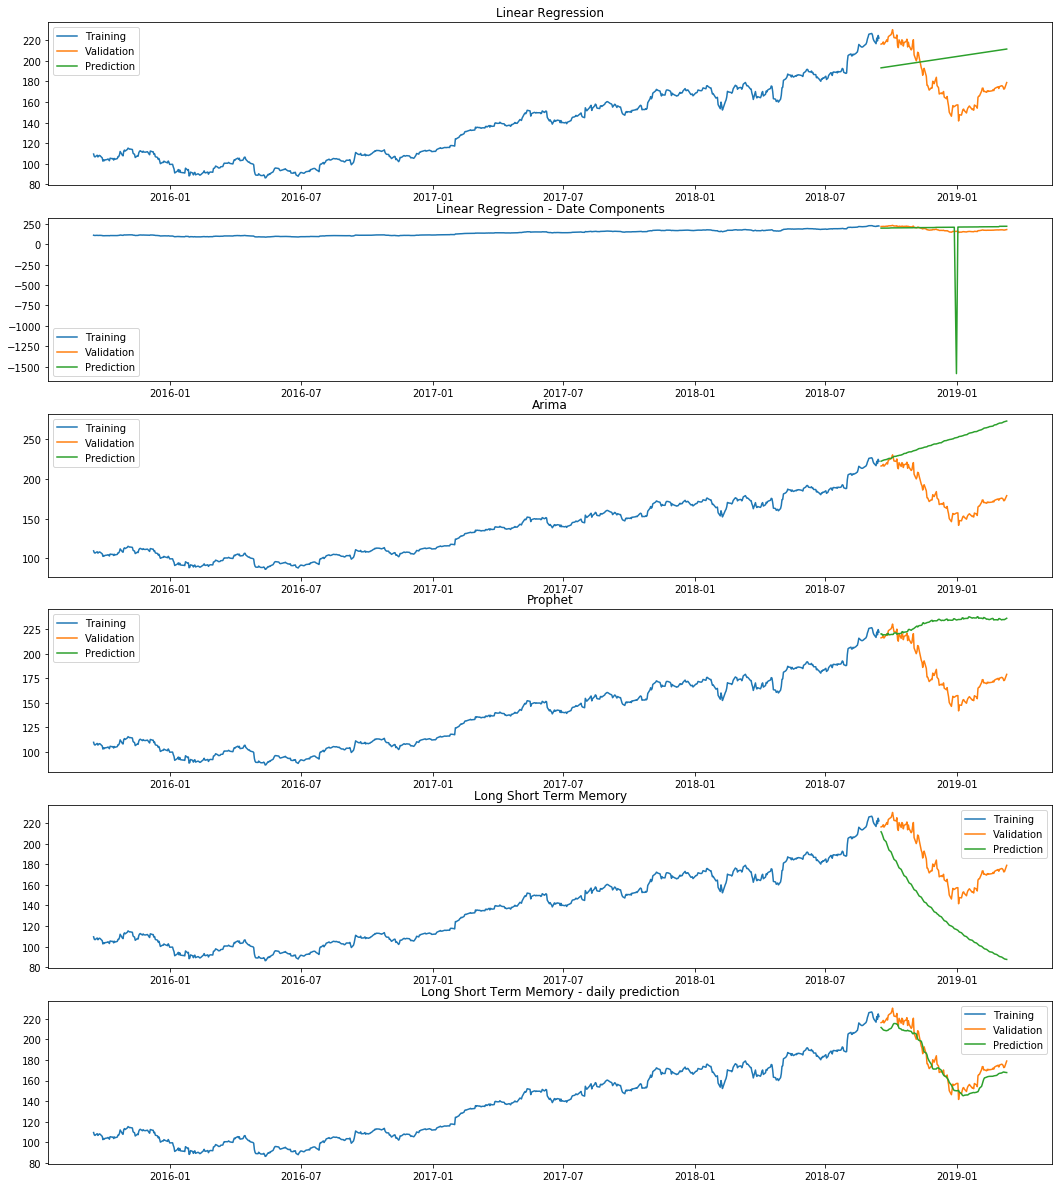

In [24]:
ds = Dataset.loadDatasetFromFile(dataset_filename)
results = perform_evaluation('eval2', ds, 'AAPL', str_to_datetime('2015-09-16'), str_to_datetime('2018-09-15'))

In [25]:
create_rmse_report(results)

In [26]:
create_improvement_report(results)

#### 3nd Example

In this third example, it is performed an evaluation now the ticker symbol DWDP (DowDuPont Inc.) in the same previous period, however this company only have historical records from August 2017, an interesting aspect about this stock is that it doesn't seem to be correlated with the DJIA.

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=870.987, BIC=878.013, Fit time=0.036 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=811.743, BIC=825.797, Fit time=0.420 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=727.450, BIC=741.504, Fit time=1.749 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=729.071, BIC=746.638, Fit time=2.449 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=872.924, BIC=883.465, Fit time=0.123 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=729.018, BIC=746.585, Fit time=7.282 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=728.300, BIC=749.381, Fit time=8.830 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=726.212, BIC=736.752, Fit time=1.146 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12);

/usr/local/lib/python3.5/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Epoch 1/2
 - 51s - loss: 0.0222
Epoch 2/2
 - 50s - loss: 0.0153


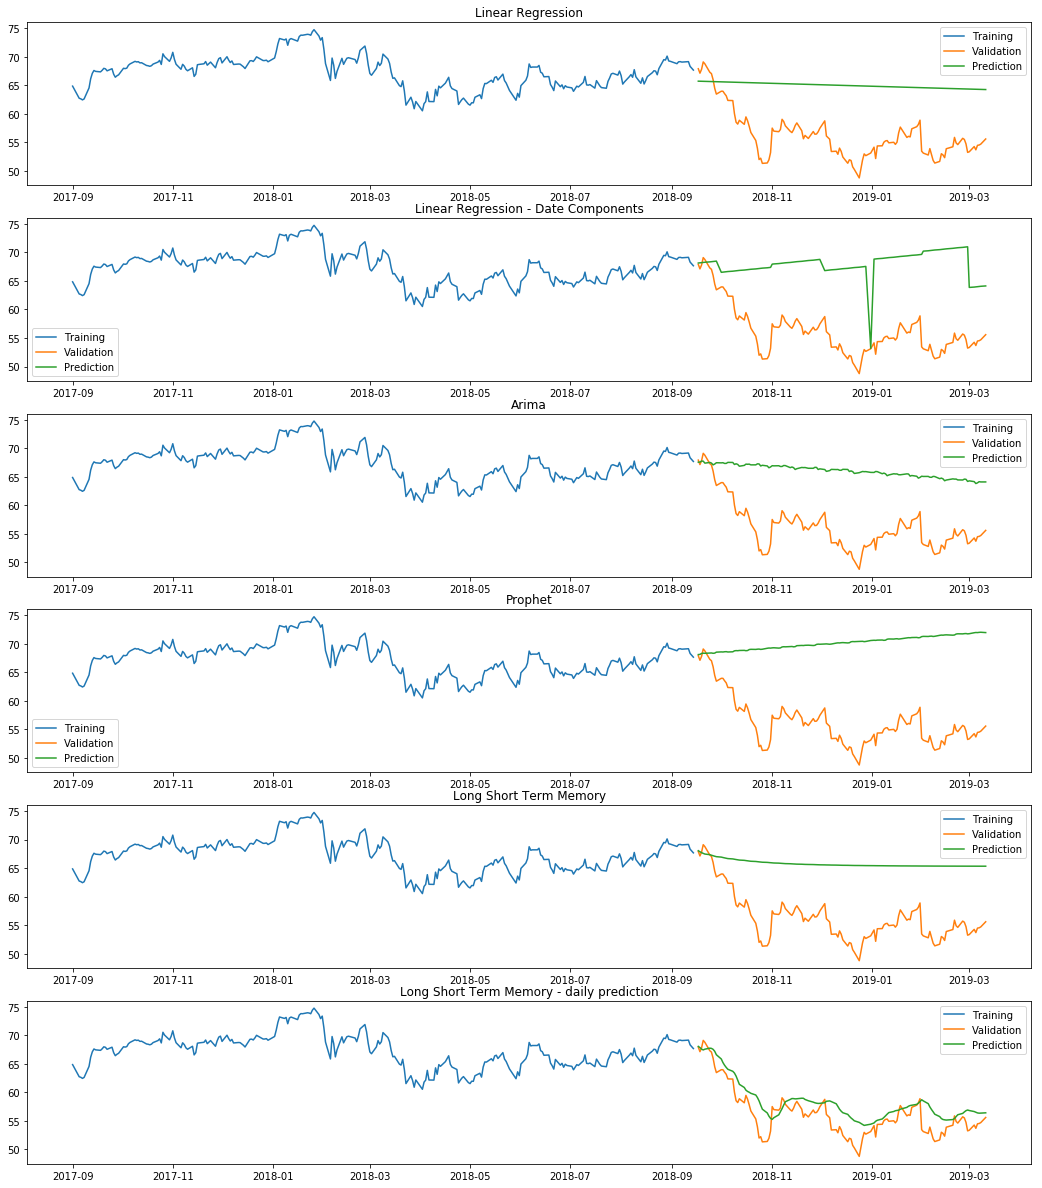

In [27]:
ds = Dataset.loadDatasetFromFile(dataset_filename)
results = perform_evaluation('eval3', ds, 'DWDP', str_to_datetime('2015-09-16'), str_to_datetime('2018-09-15'))

In [28]:
create_rmse_report(results)

In [29]:
create_improvement_report(results)

----------------------------------------

## Results

Let's get an array of ticker symbols, execpt 'DWDP', because it doesn't have enough historical records to do an evaluation with 750 (around 3 years) back.

In [30]:
symbols = []
for ticker_symbol in Dataset.DJIA_TICKERS:
    if ticker_symbol != 'DWDP':
        symbols.append(ticker_symbol)

Selecting a random ticker symbol and random dates for the date range of the training, the training range should be have 750 records for training and should be old enough to have 120 trading days ahead available in the dataset to perform the validation.

In [31]:
ticker_symbol = random.choice(symbols)

dates = ds.getDataframe(ticker_symbol=ticker_symbol).date
dates = dates[:-120]
random_date_idx = random.choice(range(0, len(dates) - 750))

start_training = dates[random_date_idx]
end_training = dates[random_date_idx + 750]

print('Ticker: {}, Start Training: {:%Y-%m-%d}, End Training: {:%Y-%m-%d}'\
      .format(ticker_symbol, start_training, end_training))

Ticker: WBA, Start Training: 2015-04-21, End Training: 2018-04-12


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2330.320, BIC=2353.340, Fit time=5.863 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2779.809, BIC=2789.017, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2555.840, BIC=2574.256, Fit time=0.987 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2332.591, BIC=2351.007, Fit time=4.458 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2332.178, BIC=2359.802, Fit time=5.868 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2780.137, BIC=2798.552, Fit time=0.700 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2332.193, BIC=2359.817, Fit time=24.193 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2333.148, BIC=2365.375, Fit time=24.671 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2330.387, BIC=2358.010, Fit time=5.857 seconds
Fit ARIMA: order=(1, 1, 0)

/usr/local/lib/python3.5/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


Epoch 1/2
 - 166s - loss: 0.0091
Epoch 2/2
 - 165s - loss: 0.0039


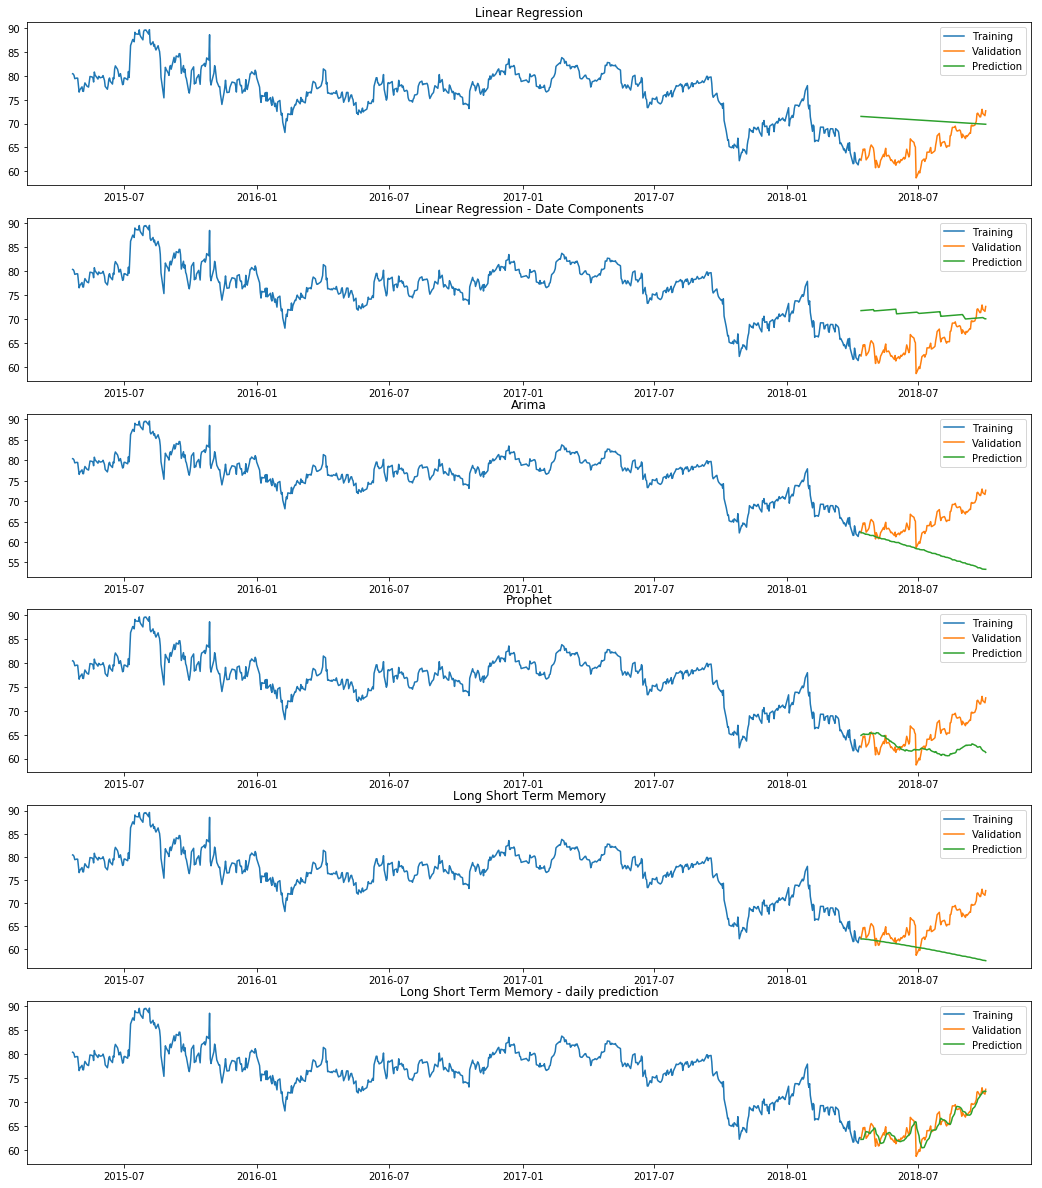

In [32]:
ds = Dataset.loadDatasetFromFile(dataset_filename)
results = perform_evaluation('random_eval', ds, ticker_symbol, start_training, end_training)

In [33]:
create_rmse_report(results)

In [34]:
create_improvement_report(results)

----------------------------------------

## In production

In [40]:
production_dataset_filename = os.path.join('data', 'djia_prod.pkl')

In [41]:
# Loading the oldest available dataset
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140324-20190322.pkl'))
# Updating the dataset with the most recent data available at the moment
ds.updateData()
# Saving the dataset to be used as the production dataset
ds.saveDataToFile(production_dataset_filename)

'data/djia_prod.pkl'

In [42]:
# Loading the production dataset
ds = Dataset.loadDatasetFromFile(production_dataset_filename)

In [ ]:
# If necessary
# Updating the production dataset ...
ds.updateData()
# ... and saving it with the most recent data
ds.saveDataToFile(production_dataset_filename)

----------------------------------------

In [35]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook StockForecasting.ipynb to html',
 '[NbConvertApp] Writing 3288742 bytes to StockForecasting.html']